In [1]:
import torch
import numpy as np
import sklearn
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

##  Loading in Data

In [2]:
df_wines = pd.read_csv("wines.csv")
df_wines.head()

,Alcohol %,Malic Acid,Ash,Alkalinity,Mg,Phenols,Flavanoids,Phenols.1,Proantho-cyanins,Color intensity,Hue,OD280 315,Proline,Start assignment,ranking
0,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,1
1,13.24,2.59,2.87,21.0,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735,1,1
2,14.83,1.64,2.17,14.0,97,2.8,2.98,0.29,1.98,5.20,1.08,2.85,1045,1,1
3,14.12,1.48,2.32,16.8,95,2.2,2.43,0.26,1.57,5.00,1.17,2.82,1280,1,1
4,13.75,1.73,2.41,16.0,89,2.6,2.76,0.29,1.81,5.60,1.15,2.90,1320,1,1


In [3]:
df_feats = df_wines.copy().drop(columns = ['Start assignment', 'ranking'])
df_feats.head()

,Alcohol %,Malic Acid,Ash,Alkalinity,Mg,Phenols,Flavanoids,Phenols.1,Proantho-cyanins,Color intensity,Hue,OD280 315,Proline
0,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.24,2.59,2.87,21.0,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
2,14.83,1.64,2.17,14.0,97,2.8,2.98,0.29,1.98,5.20,1.08,2.85,1045
3,14.12,1.48,2.32,16.8,95,2.2,2.43,0.26,1.57,5.00,1.17,2.82,1280
4,13.75,1.73,2.41,16.0,89,2.6,2.76,0.29,1.81,5.60,1.15,2.90,1320


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_feats.values)
ar_feats_nml = scaler.transform(df_feats.values)

In [5]:
df_feats_nml = pd.DataFrame(data = ar_feats_nml, columns = df_feats.columns)
df_feats_nml.head()

,Alcohol %,Malic Acid,Ash,Alkalinity,Mg,Phenols,Flavanoids,Phenols.1,Proantho-cyanins,Color intensity,Hue,OD280 315,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
2,2.259772,-0.625086,-0.718336,-1.650049,-0.192495,0.808997,0.954502,-0.578985,0.681738,0.061386,0.537671,0.336606,0.949319
3,1.382733,-0.768712,-0.170035,-0.809251,-0.332922,-0.152402,0.402320,-0.820719,-0.036617,-0.025128,0.932531,0.294232,1.697675
4,0.925685,-0.544297,0.158946,-1.049479,-0.754202,0.488531,0.733629,-0.578985,0.383884,0.234414,0.844785,0.407228,1.825055


## 2a:

### Gaussian Naive Bayes

In [6]:
class NaiveBayesClassifier():
    def __init__(self):
        self.type_indices={}    # store the indices of wines that belong to each cultivar as a boolean array of length 178
        self.type_stats={}      # store the mean and std of each cultivar
        self.ndata = 0
        self.trained=False
    
    @staticmethod
    def pdf(x, feat_mean, feat_std):
        # Gaussian Probability Distribution Function
        cmn_scal = 2 * (feat_std)**2
        scalar = (1 / np.sqrt(np.pi * cmn_scal))
        exponent = -1 *(((x - feat_mean) **2) / cmn_scal)
        prob = scalar * np.exp(exponent)
        return prob
    
    @staticmethod
    def calculate_statistics(x_values):
        # Returns a list with length of input features. 
        # Each element is a tuple, with the input feature's average and standard deviation
        n_feats=x_values.shape[1]
        return [(np.average(x_values[:,n]), np.std(x_values[:,n])) for n in range(n_feats)]
    
    @staticmethod
    def calculate_prob(x_input, mn_std_clfts):
        """
        Calculate the probability that the input features belong to a specific class(P(X|C)), 
        defined by the statistics of features in that class
        x_input: np.array shape(nfeatures)
        
        Other additional parameters as needed for calculating probabilities.
        Hint: this can be a list of tuple [(mean1,std1), (means2,std2),...]
        """ 
        ft_cnd_pbs = [NaiveBayesClassifier.pdf(x_input[i], mn_std_clfts[i][0], mn_std_clfts[i][1]) for i in range(len(mn_std_clfts))]
        init_prob = np.prod(ft_cnd_pbs)
        return init_prob
    
    def fit(self,xs,ys):
        # Train the classifier by calculating the statistics of different features in each class
        self.ndata = len(ys)
        for y in set(ys):
            type_filter= (ys==y)
            self.type_indices[y]=type_filter
            self.type_stats[y]=self.calculate_statistics(xs[type_filter])
        self.trained=True
            
    def predict(self, xs):
        # Do the prediction by outputing the class that has highest probability
        if len(xs.shape)>1:
            print("Only accepts one sample at a time!")
        if self.trained:
            guess=None
            max_prob=0
            # P(C|X) = P(X|C)*P(C) / sum_i(P(X|C_i)*P(C_i)) (deniminator for normalization only, can be ignored)
            #for y_type in self.type_stats:
            for y in self.type_indices.keys():
                class_prob = self.type_indices[y].sum() / len(self.type_indices[y])
                prob= class_prob * self.calculate_prob(xs, self.type_stats[y])
                if prob>max_prob:
                    max_prob=prob
                    # guess=y_type
                    guess = y
            return guess
        else:
            print("Please train the classifier first!")

In [7]:
NBC = NaiveBayesClassifier()
NBC.fit(df_feats.values, df_wines['ranking'].values)

In [8]:
# Probability for Alcohol having value of 13 given wine belongs to cultivar 1
NBC.pdf(13, NBC.type_stats[1][0][0], NBC.type_stats[1][0][1])

0.23236757865410357

I chose the functional form of a gaussian distribution because the features are continuous and assuming the features follow a gaussian distribution. I don't think I can make the assumption that the features are independent since the covariance matrix of the features dataset has nonzero values along its diagonal. 

## 2b:

A performance tester:

In [9]:
def calculate_accuracy(model,xs,ys):
    y_pred=np.zeros_like(ys)
    for idx,x in enumerate(xs):
        y_pred[idx]=model.predict(x)
    return np.sum(ys==y_pred)/len(ys)

In [10]:
# Results are consistent regardless of shuffling of data, so there is no bias in the dataset influencing accuracy
from sklearn.model_selection import KFold, train_test_split
kf = KFold(n_splits= 3, shuffle= True)
ls_trnacs = []
ls_tstacs = []
for train_indices, test_indices in kf.split(df_feats_nml, df_wines['ranking']):
    X_train = df_feats_nml.values[train_indices]
    y_train = df_wines['ranking'][train_indices]
    X_test = df_feats_nml.values[test_indices]
    y_test = df_wines['ranking'][test_indices]
    NBC = NaiveBayesClassifier()
    NBC.fit(X_train, y_train)
    # train accuracy
    train_ac = calculate_accuracy(NBC, X_train, y_train)
    ls_trnacs.append(train_ac)
    print("Train accuracy: " + str(train_ac))
    # test accuracy
    test_ac = calculate_accuracy(NBC, X_test, y_test)
    ls_tstacs.append(test_ac)
    print("Test accuracy: " + str(test_ac))

Train accuracy: 0.9830508474576272
Test accuracy: 0.9666666666666667
Train accuracy: 0.9831932773109243
Test accuracy: 0.9830508474576272
Train accuracy: 0.9915966386554622
Test accuracy: 0.9830508474576272


Yes, Gaussian Naive Bayes performs just as well as previous methods like simulated annealing and is arguably better because of Gaussian Naive Bayes' superior accuracy metrics on the test data.

## 3a

In [11]:
class LinearNN(nn.Module):
    def __init__(self):
        super().__init__() # initializes the gradient descent
        self.layers = nn.Sequential(
        nn.Linear(13,3)) 
    def forward(self,x):
        return self.layers(x)

In [12]:
X_subset = torch.tensor(X_train[:10], dtype = torch.float)

In [13]:
model = LinearNN()
model(X_subset)

tensor([[-0.2804,  0.3729, -0.1688],
        [ 0.2009,  0.9123, -0.0155],
        [-0.4076,  0.9273, -0.4429],
        [-0.2019,  0.9883, -0.1090],
        [-0.1559,  0.9906,  0.1022],
        [ 0.3083,  0.6459,  0.4592],
        [-0.5277,  0.6809, -0.4612],
        [-0.8198,  0.6748, -0.7789],
        [-0.1792,  0.6631, -0.2664],
        [-0.1447,  0.6387, -0.0847]], grad_fn=<AddmmBackward0>)

In [14]:
model(X_subset).sum(dim = 1)

tensor([-0.0763,  1.0976,  0.0768,  0.6774,  0.9368,  1.4134, -0.3081, -0.9240,
         0.2175,  0.4093], grad_fn=<SumBackward1>)

In [15]:
class LinearNN(nn.Module):
    def __init__(self):
        super().__init__() # initializes the gradient descent
        self.layers = nn.Sequential(
        nn.Linear(13,3),
        nn.Softmax(dim = 1)) 
    def forward(self,x):
        return self.layers(x)

In [16]:
model = LinearNN()
model(X_subset)

tensor([[0.3038, 0.3179, 0.3784],
        [0.2447, 0.4314, 0.3239],
        [0.2556, 0.3055, 0.4389],
        [0.2453, 0.3685, 0.3862],
        [0.3332, 0.3667, 0.3001],
        [0.3331, 0.4428, 0.2241],
        [0.3079, 0.2605, 0.4316],
        [0.2906, 0.2164, 0.4930],
        [0.3241, 0.2939, 0.3820],
        [0.3038, 0.3366, 0.3595]], grad_fn=<SoftmaxBackward0>)

In [17]:
model(X_subset).sum(dim = 1)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SumBackward1>)

Softmax appears to normalize all of the values of the output to sum up to 1. Because of this change, the output appears to function as probabilities and indicate they are probabilities. Without the softmax activation function layer, it is tough to make any interpretations on the meaning of the output.

## 3b:

In [18]:
class LinearNN(nn.Module):
    def __init__(self):
        super().__init__() # initializes the gradient descent
        self.layers = nn.Sequential(
        nn.Linear(13,3),
        nn.Softmax(dim = 1)) 
    def forward(self,x):
        return self.layers(x)

In [19]:
nn_labels = df_wines['ranking'] - 1
set(nn_labels)

{0, 1, 2}

In [20]:
# you can use this framework to do training and validation           
def train_and_val(model,train_X,train_y,epochs,draw_curve=True):
    """
    Parameters
    --------------
    model: a PyTorch model
    train_X: np.array shape(ndata,nfeatures)
    train_y: np.array shape(ndata)
    epochs: int
    draw_curve: bool
    """
    ### Define your loss function, optimizer. Convert data to torch tensor ###
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 2e-3)
    torch_feats = torch.tensor(train_X, dtype = torch.float)
    torch_labels = torch.tensor(train_y, dtype = torch.long)
    
    ### Split training examples further into training and validation ###
    kf = KFold(n_splits= 3, shuffle = True)
    train_acc_all = []
    test_acc_all = []
    for train_ind, test_ind in kf.split(torch_feats, torch_labels):
        X_train = torch_feats[train_ind]
        y_train = torch_labels[train_ind]
        X_test = torch_feats[test_ind]
        y_test = torch_labels[test_ind]
        
        trainval_X, X_valid, trainval_y, y_valid = train_test_split(X_train, y_train, test_size=0.20)
        
        val_array=[]
        lowest_val_loss = np.inf
    
        for i in range(epochs):
            ### Compute the loss and do backpropagation ###
            pred = model(trainval_X)
            loss = loss_func(pred,trainval_y)
            optimizer.zero_grad() # Set current gradient to 0
            loss.backward() # Propagate loss backward through layers
            optimizer.step() # Step an iteration where an iteration is another instance of tuning weights via gradient descent
        
            ### compute validation loss and keep track of the lowest val loss ###
            # error probably at the val_error line
            val_pred = model(X_valid)
            val_error = loss_func(val_pred, y_valid)
            if val_error < lowest_val_loss:
                weights = model.state_dict()
                lowest_val_loss = val_error
            val_array.append(val_error.detach().numpy())
    
        # The final number of epochs is when the minimum error in validation set occurs 
        final_epochs=np.argmin(val_array)+1
        print("Number of epochs with lowest validation:",final_epochs)
        ### Recover the model weight ###
        model.load_state_dict(weights)
        
        train_pred_prob = model(X_train)
        train_predclass = np.argmax(train_pred_prob.detach().numpy(), axis = 1) 
        train_acc = np.sum((train_predclass == y_train.numpy()) / len(train_predclass))
        print("Train accuracy:",train_acc)
        print("Train error:", 1-train_acc)
        print("--------------------------------")
        train_acc_all.append(train_acc)
        
        test_pred_prob = model(X_test)
        test_predclass = np.argmax(test_pred_prob.detach().numpy(), axis = 1)
        test_acc= np.sum((test_predclass == y_test.numpy()) / len(test_predclass))
        test_acc_all.append(test_acc)
        print("Test accuracy:",test_acc)
        print("Test error:", 1-test_acc)
        print("--------------------------------")
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    return model


Number of epochs with lowest validation: 900
Train accuracy: 1.0000000000000002
Train error: -2.220446049250313e-16
--------------------------------
Test accuracy: 0.9833333333333334
Test error: 0.016666666666666607
--------------------------------
Number of epochs with lowest validation: 349
Train accuracy: 0.9999999999999997
Train error: 3.3306690738754696e-16
--------------------------------
Test accuracy: 0.9830508474576269
Test error: 0.016949152542373058
--------------------------------
Number of epochs with lowest validation: 900
Train accuracy: 0.9999999999999997
Train error: 3.3306690738754696e-16
--------------------------------
Test accuracy: 0.9830508474576269
Test error: 0.016949152542373058
--------------------------------


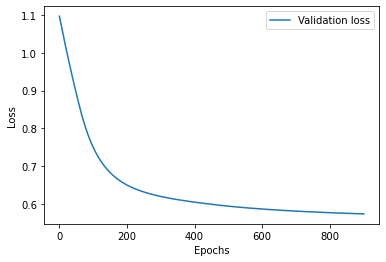

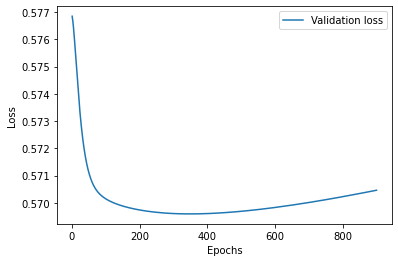

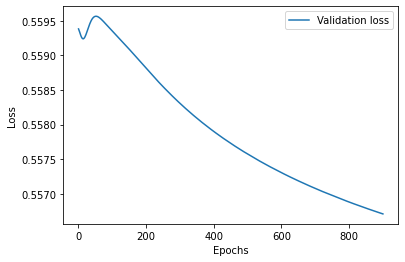

In [21]:
linNN = LinearNN()
trained_model = train_and_val(linNN, df_feats_nml.values, nn_labels,900)

This classification is excellent! Consistently correctly classifying at least 97% of the test dataset every time.